# Quick intro

This is a jupyter notebook for testing / coding. So far, each code block is a separate test; unlike an ordinary notebook, they are not meant to run sequentially.

First, test to see jupyter is running correctly at all:


In [1]:
import os
import sys

print("hi!!!")
print("hi!!!")
print("hi!!!")
print("hi!!!")
print("hi!!!")

hi!!!
hi!!!
hi!!!
hi!!!
hi!!!


Next, running "toypyro". This started out as a copy of Fritz's code but I hope it evolves into a working version of ours.

Yes, I will run.
populations = tensor([[455., 132.],
        [ 62.,  43.],
        [ 90., 120.],
        [ 79., 353.],
        [104., 220.],
        [219., 434.],
        [193., 389.],
        [164.,  90.],
        [193., 247.],
        [ 66., 110.],
        [162., 207.],
        [ 62., 135.],
        [598., 162.],
        [353., 836.],
        [ 95., 133.],
        [150., 114.],
        [127., 419.],
        [368., 309.],
        [197., 249.],
        [184., 336.]])
tensor([0.5084, 0.3247, 0.5471, 0.6514, 0.6651, 0.5019, 0.7383, 0.1278, 0.4673,
        0.7961, 0.5033, 0.4105, 0.1888, 0.7591, 0.1123, 0.9094, 0.8372, 0.4448,
        0.5517, 0.4489])
epoch 0 loss = 28.181323528289795
epoch 100 loss = 19.38272535800934
epoch 200 loss = 9.295216083526611
epoch 300 loss = 22.572052001953125
epoch 400 loss = 23.567858457565308
epoch 500 loss = 22.46941649913788
epoch 600 loss = 12.212302207946777
epoch 700 loss = 8.997203350067139
epoch 800 loss = 5.004081726074219
epoch 900 loss = 7.0002808

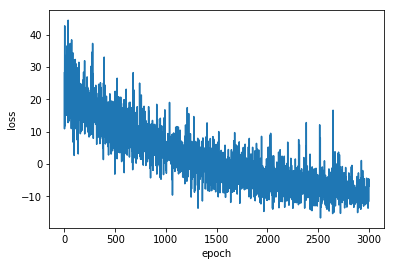

In [4]:
from importlib import reload
import toypyro #import *
reload(toypyro)
from toypyro import *

Next, run "polytopize", which has all of my pre-Fritz attempts to code.

In [117]:
import sys
import hessian

from importlib import reload
import polytopize #import *
reload(polytopize)
from polytopize import *


Yes, I will run.
ge fail
loc tensor([[ 0.5255,  2.2841, -5.1064]])
polytopedLoc tensor([[ 8.8502e-01,  4.2017e-01, -1.4901e-08,  2.4610e-01],
        [ 6.7613e-01,  1.7744e-01,  3.6027e-01,  3.6274e-02]])
Reloading cmult...
total count 3 <class 'int'>
callable? <bound method TorchDistributionMixin.__call__ of Multinomial()>
callable? <bound method TorchDistributionMixin.__call__ of TorchCMult()>
Sampling multinomial: tensor([0., 3.])
Sampling cm2: tensor([1., 2.])
total count 4 <class 'int'>
total count 5 <class 'int'>
tensor(5.6022, grad_fn=<NegBackward>) tensor([[112.2500]])


In [118]:
loc2

result = polytopize(R,C,loc2,indep)

loc3 = depolytopize(R,C,result,indep)

print(loc2)
print(result-indep)
print(loc3)

tensor([[-2.2902, -0.7166],
        [-0.2286,  3.0803],
        [ 0.1990,  4.6613]], requires_grad=True)
tensor([[-0.4949, -0.1548,  0.6497],
        [-0.0494,  0.6656, -0.6162],
        [ 0.0430,  1.0073, -1.0503],
        [ 0.5013, -1.5180,  1.0167]], grad_fn=<SubBackward0>)
tensor([[-2.2902, -0.7166],
        [-0.2286,  3.0803],
        [ 0.1990,  4.6613]], grad_fn=<SliceBackward>)


Finally, this is a cell for directly experimenting with pytorch and/or pyro. Basically, for getting the tensor syntax right. 

In [110]:
import torch
import cmult
import pyro
from importlib import reload
reload(cmult)
from cmult import CMult

#print(CMult(probs=torch.tensor([1., 1., 1., 1.])).log_prob(torch.tensor([1.2, 1.5, 1., 1.])))

#print(CMult(100, torch.tensor([ 1., 1., 1., 1.])).sample())

R, C = (3,4)

y = pyro.distributions.Normal(0.,4.).sample(torch.Size([R-1,C-1]))


w = torch.cat((y,-y.sum(1).unsqueeze(1)),1)
w = torch.cat((w,-w.sum(0).unsqueeze(0)),0)

#print(w)
b = w.argmax()
print(b)
print(w,w[b//C,b % C])

tt = torch.zeros(R,C)
print(tt,R,C,tt[:(R-1),:(C-1)])

Reloading cmult...
tensor(3)
tensor([[ 0.8137, -4.4322, -6.2344,  9.8529],
        [-2.8682,  3.0514,  1.8272, -2.0104],
        [ 2.0546,  1.3808,  4.4071, -7.8425]]) tensor(9.8529)
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]) 3 4 tensor([[0., 0., 0.],
        [0., 0., 0.]])


## Overview

Most SVI problems in pyro are coded as a model, a generic guide (such as: multivariate Gaussian in all parameters), and specific observations/data (passed as arguments to svi.step). For EI, that's going to be different; the observations are going to be built into the guide function, leaving nothing to include in the "data" argument to svi.step.

That means there is a lot of work for the guide to do. As usual, it must establish reasonable distributional families for the posterior of each of the hyperparameters. But for the latent parameters, the job of the guide is to take a "relative strength" number for each race/candidate/precinct combo, and turn that into a number of votes for each combo, such that those numbers obey all the constraints set by observations. This means that for each precinct (considered separately), the latent guide must:

-Find the "center point" where candidate preference is independent of race.

-Find the "basis vectors" (actually, there are more than enough of them to form a basis) which determine the directions to move in the space.

-For any given set of "relative strengths" which is a distance $d$ in a direction $\theta$, find the first constraint violated when moving in that direction, and the distance $r$ between the origin and that constraint.

-Project the "relative strengths" onto the numbers of votes, by moving $r(1-e^{-d})$ in direction $\theta$.

#### a = zs(2,2,2,2)
a[0,1,1,1] = 2
print(a[1,1])
print(a[0,1])
print(torch.max(a))
print(torch.distributions.exponential.Exponential(ts([1])).sample(4))

In [78]:
print("hi","world")
a = zs(2,2,2,2)
a[0,1,1,1] = 2 
print(torch.max(a[0,1])) 
print(pyro.distributions.Exponential(1.).sample(torch.Size([3])))
a.add_(torch.ones(2,2,2))
print(torch.exp)

hi world
tensor(2.)
tensor([0.4798, 0.3568, 0.3053])
<built-in method exp of type object at 0x1a1c450470>
